In [510]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline



In [511]:
# data = pd.read_excel("data_test-1.xls", header=26, skiprows=0)
raw_data = pd.read_excel("python_data.xls")
data = raw_data.copy()




## Cleaning Data

In [ ]:
data = data.dropna(axis=1, how='all').dropna(axis=0, how='all')

In [512]:
# removing any unnamed columns
for col in data.columns:
    if 'Unnamed' in col:
        del data[col]

In [618]:
data = data[data['MAT $ 2012'] != 0]
data = data[data['MAT $ 2013'] != 0]
data = data[data['MAT $ 2014'] != 0]


## Adding Features

In [619]:
# mean of occ cost % over 3 years
data['avg_occ_3yrs'] = data[['MAT Occ Cost % 2012', 'MAT Occ Cost % 2013', \
                                     'MAT Occ Cost % 2014']].apply(np.sum, axis=1)/3

In [643]:
imp_feat_list = ['Lease', 'MAT $ CAGR ', 'MAT $ (mo. slope) ', 'avg_occ_3yrs', 'MAT $ PSF Var_Avg ', 'MAT $ PSF Var_slope ', \
                'MAT Occ Cost % (slope) ', 'MAT Occ Cost % CAGR ', 'MAT Occ Cost % CAGR to MAT $ Var ', 'MAT Occ Cost %_Avg_Var _2014',\
                'MAT Occ Cost %_1yr_slope _', 'MAT Occ Cost %_2yr_slope _', 'Month $ PSF % Var_1yr_avg _', 'Month $ PSF % Var_2yr_avg _',\
                'Month $ PSF % Var (1 yr. slope) _', 'Month $ PSF % Var (2 yr. slope) _', 'Non-Holiday Month % Var _2014', \
                'Holiday Month % Var _2014', 'Lease Term (mo.)', 'AR_Past_Due_MAX', 'AR_% of Billings Owed_MAX', \
                'AR_61 - 90_MAX', 'AR_Over 90_MAX', 'AR_2monthover_MAX', 'Defaulted']

In [621]:
data.head()

,Lease,Space,Product Category,Space Type,Shop Count 2014,Area 2014,MAT $ 2012,MAT $ 2013,MAT $ 2014,MAT $ CAGR,...,AR_2monthover_6-14,AR_Past_Due_MAX,AR_1 - 30_MAX,AR_31 - 60_MAX,AR_61 - 90_MAX,AR_Over 90_MAX,AR_MTD Billings_MAX,AR_% of Billings Owed_MAX,AR_2monthover_MAX,avg_occ_3yrs
0,37247,0112234 1000,SF21 US Food Service,"In-Line Units 0-9,999 SF",0,0,221541.00,211611.00,22000.00,-0.536920,...,0,18709.21,8473.31,0.00,9382.91,852.99,8473.31,2.208017,1,0.530058
1,27469,0112243 O358,SF11 US Food Court,"Food Court 0-9,999 SF",0,0,207989.00,167542.22,13407.00,-0.599044,...,0,24478.59,6809.72,0.00,9528.30,8140.57,6809.72,3.594654,1,0.549648
2,51346,0112253 FC6,SF11 US Food Court,"Food Court 0-9,999 SF",0,0,231957.00,216441.00,15200.00,-0.596839,...,0,17163.71,7464.11,0.00,7461.24,2238.36,7464.11,2.299499,1,0.565102
3,342043,0112327 218,S111 US Women's Fashion,"In-Line Units 0-9,999 SF",0,0,639872.06,598754.70,101942.13,-0.457891,...,0,21098.70,19213.71,0.00,0.00,1884.99,19213.71,1.098107,1,0.414918
4,20935,0112230 E2,S111 US Women's Fashion,"In-Line Units 0-9,999 SF",0,0,749929.89,731330.94,134231.48,-0.436434,...,1,-18100.27,0.00,-42331.17,6451.03,17779.87,0.00,0.000000,1,0.183486


In [622]:
data.shape

(1519, 236)

### Parsing Out Inline Tenants

In [623]:
INL_data = data[data['Lease Space Type-Calc'] == 'INL']
# below code if i want to include multiple tenant types
# stk_list = ['INL']
# INL_data = [data['Lease Space Type-Calc'].isin(stk_list)]
INL_data.shape

(1167, 236)

### % of tenants that have defaulted within Inline dataset

In [624]:
INL_DEF_Tenants = INL_data[INL_data['Defaulted'] == 1]
print("Number of leases in dataset: ", len(INL_data))
print("Number of defaulted leases in dataset: ", len(INL_DEF_Tenants))
default_percent = "{:.2f}%".format(len(INL_DEF_Tenants)/len(INL_data))  # percent of defaulted tenants in inline dataset
print("Percent of defaulted: ", default_percent)

Number of leases in dataset:  1167
Number of defaulted leases in dataset:  87
Percent of defaulted:  0.07%


In [780]:
## sorts which malls have greatest number of defaults
pop_mall_defs = INL_data['BU Number-E1'].max()
print(pop_mall_defs)
INL_data[INL_data['BU Number-E1'] == pop_mall_defs]
print("Greatest number of defaults per mall is 2")


12327
Greatest number of defaults per mall is 2


## Logistic Regression Analysis

#### SciKit Learn - Logistic Regression

In [838]:
# Import Logistic Regression & Linear regression libraries
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.grid_search import GridSearchCV
from sklearn import cross_validation


In [696]:
## create data for logarithmic regression analysis
# log_list choooses categories I want to include in analysis
log_list = imp_feat_list
log_data = INL_data[log_list].copy()  # make sure to make copy so it's more than reference
log_data = log_data.drop('Lease', axis=1)  # drop lease from log_data
log_data = log_data.dropna(axis=0)  # remove any blank values from dataframe

In [711]:
log_data_X = log_data.drop('Defaulted', axis=1)  # remove defaulted column from dataframe
log_X = log_data_X.values  # turn datatable into array
log_y = log_data['Defaulted']  

In [905]:
# Fit logistic regression model
X_train_log, X_test_log, y_train_log, y_test_log = cross_validation.train_test_split(log_X, log_y, test_size=2, random_state=0)

lr = LogisticRegression()
lr.fit(X_train_log, y_train_log)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0)

In [906]:
lr.coef_
sorted(list(zip(lr.coef_[0], log_data_X.columns)))  # pull most weighted coefficients with respective feature name

[(-0.27127397082995663, 'MAT $ PSF Var_Avg '),
 (-0.23419554158541353, 'avg_occ_3yrs'),
 (-0.21645271447647724, 'AR_2monthover_MAX'),
 (-0.16907437382280263, 'MAT Occ Cost % CAGR '),
 (-0.15581306168741521, 'Holiday Month % Var _2014'),
 (-0.14881422954730683, 'MAT $ CAGR '),
 (-0.085984117868283499, 'Month $ PSF % Var_2yr_avg _'),
 (-0.072039556267971136, 'Month $ PSF % Var_1yr_avg _'),
 (-0.062936564157248201, 'Non-Holiday Month % Var _2014'),
 (-0.024353908650628503, 'Lease Term (mo.)'),
 (-0.013706103535712045, 'MAT Occ Cost %_Avg_Var _2014'),
 (-0.011510978024498422, 'AR_% of Billings Owed_MAX'),
 (-0.0099492887540193579, 'Month $ PSF % Var (1 yr. slope) _'),
 (-0.0010225655817045175, 'MAT Occ Cost %_1yr_slope _'),
 (-0.00086074265360525288, 'MAT Occ Cost %_2yr_slope _'),
 (-2.6118472250291331e-06, 'AR_Over 90_MAX'),
 (-2.5097899208552449e-06, 'MAT $ (mo. slope) '),
 (1.8819228306662672e-05, 'AR_Past_Due_MAX'),
 (4.8373635899615983e-05, 'AR_61 - 90_MAX'),
 (0.00061794570336968634,

In [907]:
cross_val_score(lr, X_test, y_test)  # compares results of model to actual results

array([ 0.91282051,  0.90769231,  0.92227979])

In [908]:
log_pred_y = lr.predict(log_X)
list(zip(log_y, log_pred_y))

[(1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 1),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 1),
 (1, 0),
 (1, 1),
 (1, 1),
 (1, 0),
 (1, 1),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 1),
 (1, 1),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 1),
 (0, 0),
 (0, 0),
 (1, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (1, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 

#### Stats Models - Logistic Regression Analysis

In [816]:
# Statsmodel APIs
import statsmodels.api as sm
import statsmodels.formula.api as smf  # uses R style formulas


In [909]:
X_train_sm, X_test_sm, y_train_sm, y_test_sm = cross_validation.train_test_split(log_X, log_y, test_size=.5, random_state=1)

X_train = sm.add_constant(X_train_sm)
model = sm.Logit(y_train, X_train_sm)
results = model.fit()


Optimization terminated successfully.
         Current function value: 0.242323
         Iterations 10


In [910]:
cross_val_score(lr, X_test_sm, y_test_sm)

array([ 0.94358974,  0.94358974,  0.94300518])

In [911]:
results = smf.Logit(log_y, log_X, data=log_data).fit()

Optimization terminated successfully.
         Current function value: 0.192790
         Iterations 16


In [913]:
print(results.summary())

                           Logit Regression Results                           
Dep. Variable:              Defaulted   No. Observations:                 1166
Model:                          Logit   Df Residuals:                     1144
Method:                           MLE   Df Model:                           21
Date:                Wed, 04 Nov 2015   Pseudo R-squ.:                  0.2736
Time:                        18:45:14   Log-Likelihood:                -224.79
converged:                       True   LL-Null:                       -309.47
                                        LLR p-value:                 3.426e-25
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x1             0.2910        nan        nan        nan           nan       nan
x2          2.628e-06   1.58e-06      1.663      0.096      -4.7e-07  5.73e-06
x3            -6.2186      0.953     -6.524      0.0

In [833]:
sorted(list(zip(results.params, log_data_X.columns)))

[(-43.191871143819732, 'Month $ PSF % Var (2 yr. slope) _'),
 (-18.722251701399852, 'Month $ PSF % Var_2yr_avg _'),
 (-15.962821844417935, 'MAT Occ Cost %_2yr_slope _'),
 (-6.2186314406379006, 'avg_occ_3yrs'),
 (-3.8831440112877629, 'MAT Occ Cost %_1yr_slope _'),
 (-3.06714261848215, 'Non-Holiday Month % Var _2014'),
 (-2.7397667269266401, 'MAT Occ Cost % CAGR '),
 (-0.99824741325193567, 'Holiday Month % Var _2014'),
 (-0.21994394669293074, 'Month $ PSF % Var (1 yr. slope) _'),
 (-0.024819824163078263, 'Lease Term (mo.)'),
 (-2.6574771583356295e-06, 'AR_Over 90_MAX'),
 (2.6279964678157864e-06, 'MAT $ (mo. slope) '),
 (1.7307369521562853e-05, 'AR_Past_Due_MAX'),
 (3.2001193720531323e-05, 'AR_61 - 90_MAX'),
 (0.015499519745420789, 'AR_% of Billings Owed_MAX'),
 (0.029149380733378548, 'AR_2monthover_MAX'),
 (0.29099764523101507, 'MAT $ CAGR '),
 (0.47227821582155899, 'MAT $ PSF Var_Avg '),
 (0.7696040763073847, 'MAT $ PSF Var_slope '),
 (0.90231699849388736, 'MAT Occ Cost %_Avg_Var _2014'

In [565]:
# clean log data
log_data = log_data[log_data['MAT $ PSF Var_Avg '].between(-1, 1)]  # removes outliers outside of -1 and 1
log_data = log_data[log_data['MAT Occ Cost % 2012'].between(0, 1)]  #, 'MAT Occ Cost % 2013', 'MAT Occ Cost % 2014']]  
# log_data = log_data[log_data['MAT Occ Cost % 2012'].sort()]

features = ['MAT Occ Cost % 2012','MAT Occ Cost % 2013','MAT Occ Cost % 2014']

for feature in features:
    log_data = log_data[log_data[feature].between(0,1)]
    
log_data['MAT Occ Cost % 2014'].max()

0.9801018979567577

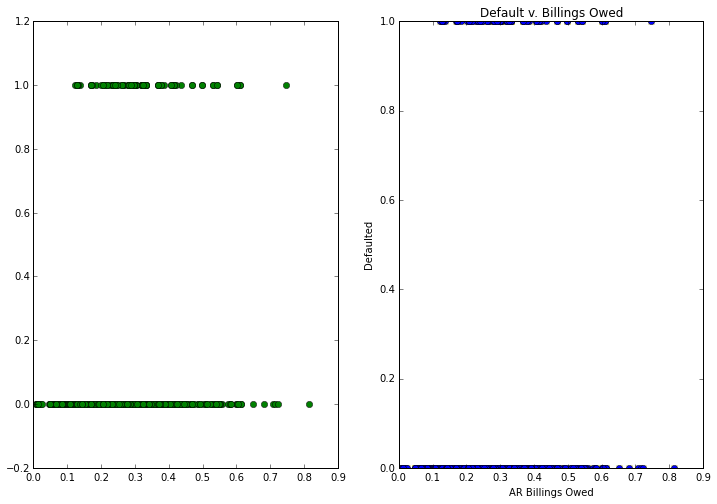

In [585]:
X = log_data['avg_occ_3yrs'].values
y = log_data['Defaulted'].values
fig, axes = plt.subplots(1,2, figsize=(12, 8))
axes[0].set_ylim((-.2, 1.2))
axes[0].plot(X, y, 'go')
axes[1].plot(X, y, 'yx')
plt.plot(X, y, 'o')
plt.xlabel('AR Billings Owed')
plt.ylabel('Defaulted')
plt.title('Default v. Billings Owed')

In [571]:
reg=1.
lr_clf = LogisticRegression(C=reg)
lr_clf.fit(X.reshape(-1,1), y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0)

In [574]:
probs = lr_clf.predict_proba(X.reshape(-1,1))[:, 1]   # returns the probability
print(probs)
predicts = lr_clf.predict(X.reshape(-1,1))   # just returns the class value
print(predicts)

[ 0.11530627  0.09542037  0.07620544 ...,  0.07540346  0.06742422
  0.07264037]
[0 0 0 ..., 0 0 0]


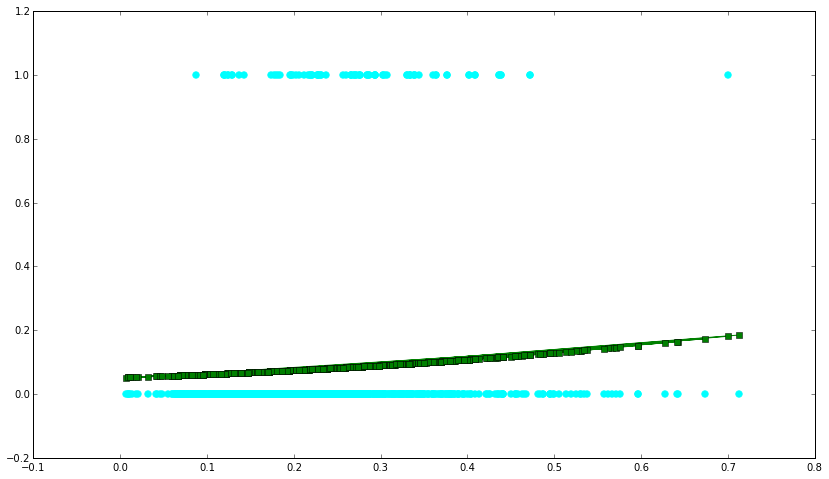

In [583]:
fig, axes = plt.subplots(1, 1, figsize=(14, 8))

# training data
plt.scatter(X, y, s=40, color='aqua', label="Training Occ % Responses") 

# probs=lr_clf.predict_proba(tempsnew.reshape(-1,1))[:,1]
# predicts=lr_clf.predict(tempsnew.reshape(-1,1))

# new test temps, as blue squares
plt.plot(X, probs, marker='s', color='green', label="Test Temperature Probabilities") 

# new test temps, scattered against the predictions, as green diamonds
# plt.scatter(tempsnew, predicts, marker='s', color="green", s=30, alpha=0.7, label="Test Temperatures Classified") 

# train_probs=lr_clf.predict_proba(X.reshape(-1,1))[:,1]
# plt.scatter(X, train_probs, marker='D', c='aqua', alpha=0.3, s=40, label="Training Temp Probabilities") #

# train_predicts=lr_clf.predict(X.reshape(-1,1))
# plt.scatter(X, train_predicts, marker='D', c='b', alpha=0.4, s=40, label="Training Data Re-Classified by Model") #

#axes.legend()

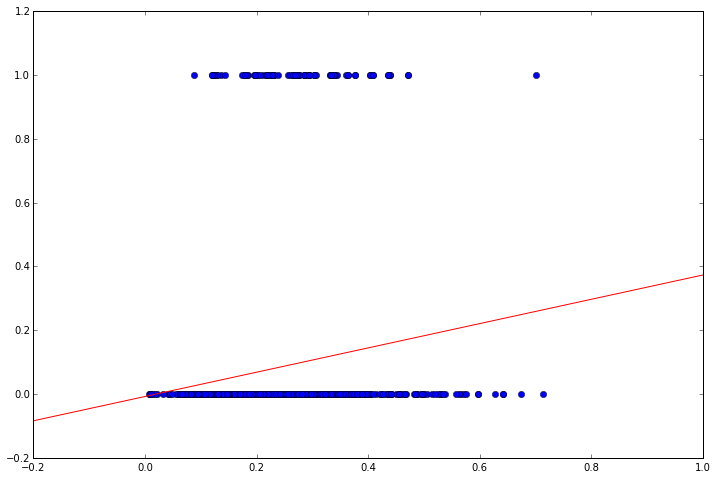

In [562]:
model = LinearRegression()
model.fit(X.reshape(-1,1), y)
X_test = np.linspace(-4000., 4000., 100).reshape(-1,1)  # 100 points between -400 and 400 then reshape
y_hat = model.predict(X_test)
fig, axes = plt.subplots(1,1, figsize=(12, 8))
axes.set_ylim((-0.2, 1.2))
axes.set_xlim((-.2,1))
plt.plot(X, y, 'o', color='b')
plt.plot(X_test, y_hat, color='r')


In [563]:
results = sm.OLS(y, X.reshape(-1,1)).fit()
results.params
# intercept, slope = results.params

# r2 = results.rsquared

# plt.plot(x, y, 'bo')
# plt.title("Price VS Sqft")
# xl = np.array([min(x), max(x)])
# yl = intercept + slope * xl
# plt.plot(xl, yl, 'r-')
# plt.show

array([ 0.35258061])

In [489]:
linreg_list = ['Lease', 'Lease Space Type-Calc', 'MAT $ CAGR', 'MAT $ PSF_Avg', 'MAT $ PSF Var_slope']
linreg_data = data[linreg_list]

KeyError: "['MAT $ CAGR' 'MAT $ PSF_Avg' 'MAT $ PSF Var_slope'] not in index"

# Random Forrest analysis

In [673]:
# import libraries

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import DecisionTree
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer
from sklearn.cross_validation import cross_val_score
from matplotlib import pyplot as plt



# Set a random seed.
rng = np.random.RandomState(0)

## try out test, train split b/c high accuracy score

In [681]:
tree_list = imp_feat_list
tree_data = data[tree_list].copy()  # make sure to make copy so it's more than reference
tree_data = tree_data.drop('Lease', axis=1)
tree_data = tree_data.dropna(axis=0)
tree_data_X = tree_data.drop('Defaulted', axis=1)


In [874]:
X_train_tree, X_test_tree, y_train_tree, y_test_tree = cross_validation.train_test_split(tree_X, tree_y, test_size=.5, random_state=1)

In [675]:
X

array([[ -5.36919824e-01,  -8.31420833e+03,   5.30057846e-01, ...,
          9.38291000e+03,   8.52990000e+02,   1.00000000e+00],
       [ -5.99043664e-01,  -8.10758333e+03,   5.49647764e-01, ...,
          9.52830000e+03,   8.14057000e+03,   1.00000000e+00],
       [ -5.96838826e-01,  -9.03154167e+03,   5.65101672e-01, ...,
          7.46124000e+03,   2.23836000e+03,   1.00000000e+00],
       ..., 
       [  5.46426494e-02,   8.13972333e+03,   2.17016288e-01, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  1.31621099e-02,   3.42475000e+03,   1.44108163e-01, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [ -6.63922675e-02,  -8.71704167e+03,   2.04470766e-01, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00]])

In [877]:
tree_X = tree_data_X.values
tree_y = tree_data['Defaulted']
# tree_data

In [878]:
# splitting data so as to avoid overfitting
X_train_tree, X_test_tree, y_train_tree, y_test_tree = cross_validation.train_test_split(tree_X, \
                                                                                         tree_y, \
                                                                                         test_size=.5, \
                                                                                         random_state=1)

In [886]:
rf = RandomForestClassifier(n_estimators=500)
rf.fit(X_train_tree, y_train_tree)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [887]:
# to research

cross_val_score(rf, X_test_tree, y_test_tree)

array([ 0.95238095,  0.95238095,  0.96812749])

In [888]:
tree_pred_y = rf.predict(X_train)

In [889]:
list(zip(tree_y, tree_pred_y))

[(1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 1),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 1),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 1),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (1, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 1),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (1, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 

## find important classifiers

In [890]:
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)

indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(10):
    print("%d. feature %s (%f)" % (f + 1, tree_data_X.columns[indices[f]], importances[indices[f]]))

Feature ranking:
1. feature Month $ PSF % Var (1 yr. slope) _ (0.080765)
2. feature AR_Past_Due_MAX (0.079383)
3. feature Holiday Month % Var _2014 (0.069537)
4. feature MAT Occ Cost % CAGR  (0.053316)
5. feature Month $ PSF % Var_1yr_avg _ (0.051275)
6. feature MAT $ CAGR  (0.051213)
7. feature MAT Occ Cost %_1yr_slope _ (0.049863)
8. feature AR_% of Billings Owed_MAX (0.048944)
9. feature Month $ PSF % Var (2 yr. slope) _ (0.046865)
10. feature Non-Holiday Month % Var _2014 (0.045819)


IndexError: index 13 is out of bounds for axis 1 with size 10

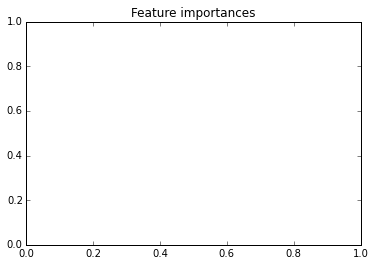

In [873]:
# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(10), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(10), indices)
plt.xlim([-1, 10])
plt.show()


DayOfWeekOfCall = [1,2,3]
DispatchesOnThisWeekday = [77, 32, 42]
​
LABELS = ["Monday", "Tuesday", "Wednesday"]
​
plt.bar(DayOfWeekOfCall, DispatchesOnThisWeekday, align='center')
plt.xticks(DayOfWeekOfCall, LABELS)
plt.show()